In [1]:
import tensorflow as tf
# current processing
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import layers
from keras.models import Sequential
from keras.layers import preprocessing
from keras.utils import plot_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import itertools
import shutil

from sklearn.metrics import confusion_matrix



2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

random_state_global = 42

pathfinal = path + 'model_history/part_a/'
pathfinal2 = path + 'model_images/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4

IMG_SIZE = (224, 224)
checkpoint_path = ''
train_dir = 'Group_20/train'
test_dir = 'Group_20/test'
val_dir = 'Group_20/val'

In [3]:
def delete_folder_contents(path_erase):
    '''
    take path to erase all data present on it
    '''
    folder_name = path_erase
    # Get all files in the folder
    files = os.listdir(folder_name)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
delete_folder_contents(pathfinal)

### Preparing Data

In [4]:
# unzip_data('Group_20.zip')

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir('Group_20')

There are 3 directories and 1 images in 'Group_20'.
There are 5 directories and 0 images in 'Group_20/test'.
There are 0 directories and 20 images in 'Group_20/test/butterfly'.
There are 0 directories and 20 images in 'Group_20/test/helicopter'.
There are 0 directories and 20 images in 'Group_20/test/ketch'.
There are 0 directories and 20 images in 'Group_20/test/brain'.
There are 0 directories and 20 images in 'Group_20/test/ewer'.
There are 5 directories and 0 images in 'Group_20/train'.
There are 0 directories and 50 images in 'Group_20/train/butterfly'.
There are 0 directories and 50 images in 'Group_20/train/helicopter'.
There are 0 directories and 50 images in 'Group_20/train/ketch'.
There are 0 directories and 50 images in 'Group_20/train/brain'.
There are 0 directories and 50 images in 'Group_20/train/ewer'.
There are 5 directories and 0 images in 'Group_20/val'.
There are 0 directories and 10 images in 'Group_20/val/butterfly'.
There are 0 directories and 10 images in 'Group_2

In [5]:
# Setup data inputs
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=True)
train_data = train_ds.map(lambda x, y: (normalization_layer(x), y))


test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle test data for prediction analysis
test_data = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_Y=[]
for images, labels in test_data.unbatch():
    test_Y.append(labels.numpy().argmax())


valid_ds = keras.utils.image_dataset_from_directory(val_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle valid data for prediction analysis
valid_data = valid_ds.map(lambda x, y: (normalization_layer(x), y))

class_names = train_ds.class_names
print(f'\nclass names are {class_names}')

Found 250 files belonging to 5 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.

class names are ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']


2023-04-24 21:54:33.064709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 21:54:33.064821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-24 21:54:33.186302: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<Figure size 1000x1000 with 0 Axes>

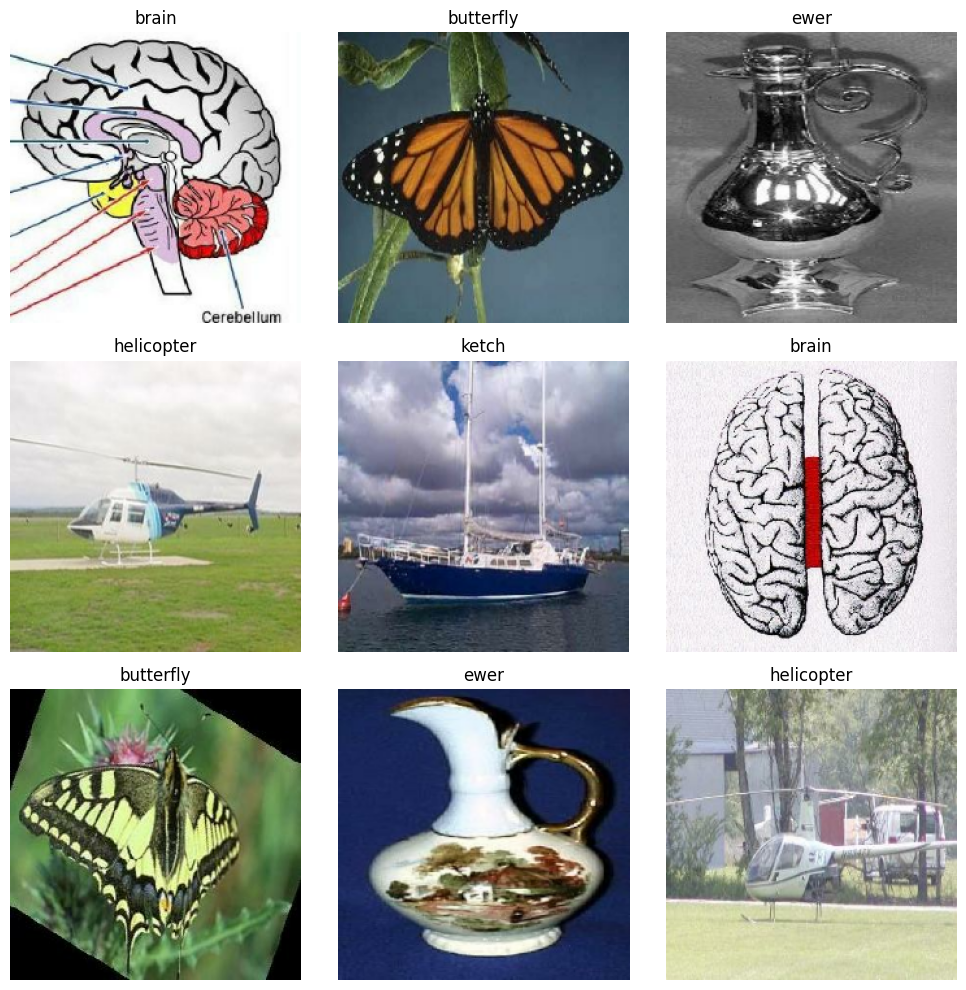

In [6]:
plt.figure(figsize=(10, 10))
fig,ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.reshape(-1)
c=0
for images, labels in train_ds.unbatch():
  ind = labels.numpy().argmax()
  if((c%5)==ind):
    ax[c].imshow(images.numpy().astype("uint8"))
    ax[c].set_title(class_names[ind])
    ax[c].axis("off")
    c+=1
    if(c==9):
      break
plt.tight_layout()
plt.show()

In [7]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_Y, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)
    

def inferences(df_model_history, model):
    print(f'Training Accuracy for model: {df_model_history["accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Validation Accuracy for model: {df_model_history["val_accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Test Accuracy for model: {model.evaluate(test_data, verbose=0)[1]*100:.2f}%')

    df_model_history.plot(title="Accuracy / Loss vs Epoch", xlabel='Epoch', ylabel='Accuracy / Loss')
    plt.show()

def makingPredictionWithCM(model):
    y_prob_a = model.predict(test_data, verbose=0)
    y_pred_a = y_prob_a.argmax(axis=1)
    make_confusion_matrix(test_Y, y_pred_a, classes=class_names)

model_arch_list = []
def plottingModel(model):
    plot_model(model,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)
    img = plt.imread(f'model_images/model.png')
    model_arch_list.append(img)
    plt.figure(figsize=(5, 10))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

def showResults(model, history):
    inferences(history, model)
    # plottingModel(model)
    makingPredictionWithCM(model)

### Callbacks

In [8]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving()

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=1,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=1)

checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 

In [9]:
initializer_1 = tf.keras.initializers.GlorotUniform(seed=random_state_global)
initializer_2 = tf.keras.initializers.GlorotUniform(seed=random_state_global+1)
initializer_3 = tf.keras.initializers.GlorotUniform(seed=random_state_global+2)
initializer_4 = tf.keras.initializers.GlorotUniform(seed=random_state_global+3)
initializer_5 = tf.keras.initializers.GlorotUniform(seed=random_state_global+4)
initializer_6 = tf.keras.initializers.GlorotUniform(seed=random_state_global+5)

### Architecture-1 (4-layer  architecture)

2023-04-24 21:54:34.377572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3000


2023-04-24 21:54:34.922204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step - loss: 1.5595 - accuracy: 0.2760 - val_loss: 1.4097 - val_accuracy: 0.5800
Epoch 2/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.2676 - accuracy: 0.5960 - val_loss: 1.1686 - val_accuracy: 0.5600
Epoch 3/3000
8/8 [==============================] - 0s 25ms/step - loss: 1.1773 - accuracy: 0.5560 - val_loss: 0.9634 - val_accuracy: 0.6400
Epoch 4/3000
8/8 [==============================] - 0s 26ms/step - loss: 0.8907 - accuracy: 0.6680 - val_loss: 0.7410 - val_accuracy: 0.8200
Epoch 5/3000
8/8 [==============================] - 0s 28ms/step - loss: 0.7111 - accuracy: 0.7560 - val_loss: 0.7025 - val_accuracy: 0.7400
Epoch 6/3000
8/8 [==============================] - 0s 27ms/step - loss: 0.5906 - accuracy: 0.7960 - val_loss: 0.7251 - val_accuracy: 0.7400
Epoch 7/3000
8/8 [==============================] - 0s 25ms/step - loss: 0.5004 - accuracy: 0.8520 - val_loss: 0.8766 - val_accuracy: 0.6400
Epoch 8/3000
8/8 [========

INFO:tensorflow:Assets written to: model_history/part_a/model_1_29.tf/assets


INFO:tensorflow:Assets written to: model_history/part_a/model_1_29.tf/assets


Epoch 29: early stopping
Training Accuracy for model: 100.00%
Validation Accuracy for model: 86.00%
Test Accuracy for model: 81.00%


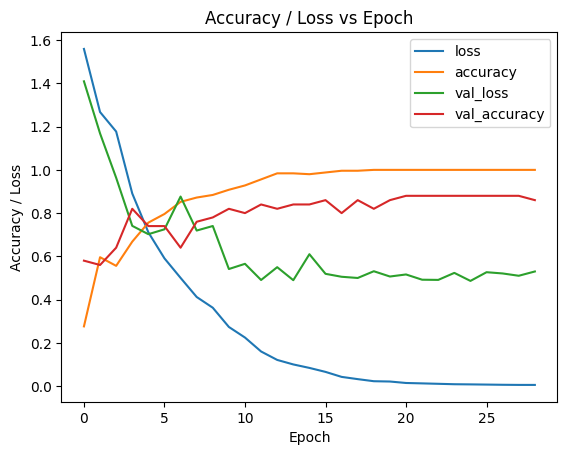

2023-04-24 21:54:44.090236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


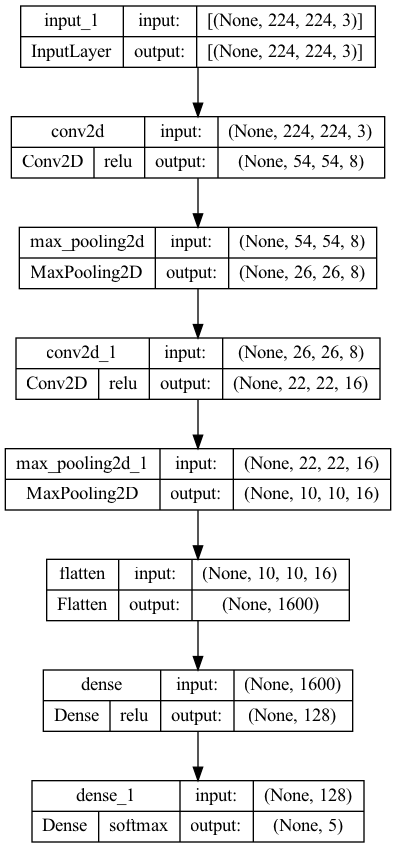

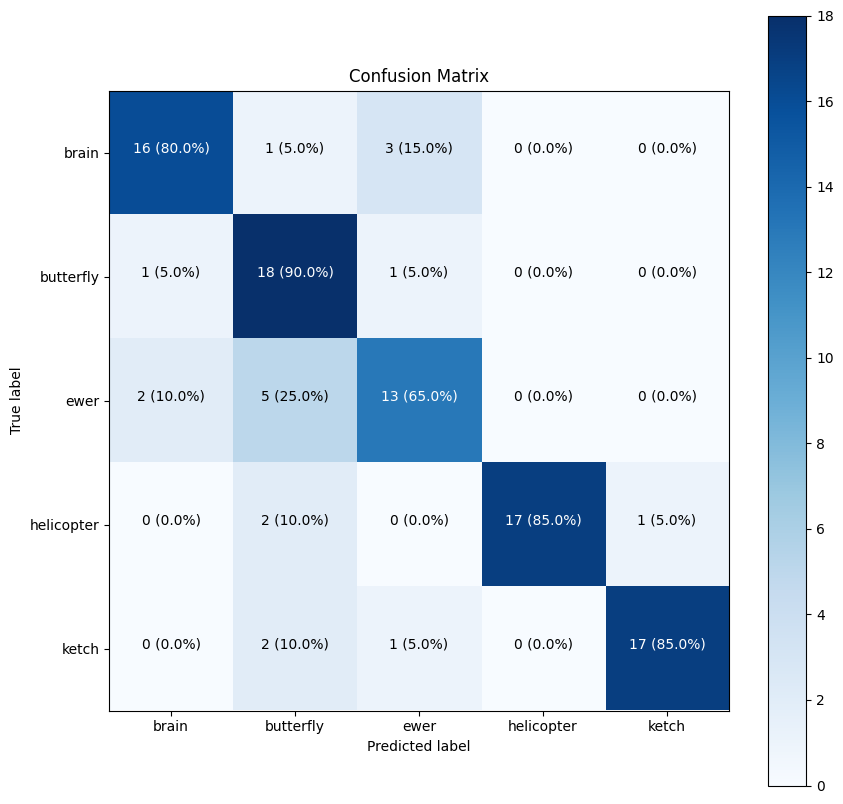

In [10]:
tf.random.set_seed(random_state_global)

model_1 = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  
  keras.layers.Conv2D(filters=8, kernel_size=11, strides=4, activation="relu", kernel_initializer=initializer_1),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="relu", kernel_initializer=initializer_2),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu", kernel_initializer=initializer_3),
  
  keras.layers.Dense(5, activation="softmax", kernel_initializer=initializer_4) # binary activation output
], name="model_1")

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(),
                    metrics=["accuracy"])

  # Evaluate the model initial losses
initial_train_loss, initial_train_acc = model_1.evaluate(train_data, verbose=0)
initial_valid_loss, initial_valid_acc = model_1.evaluate(valid_data, verbose=0)

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=epoch_val,
                        validation_data=valid_data,
                        callbacks=[model_saver, HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), early_stopping_cb],
                        verbose=1)

df_history_1 = pd.DataFrame(history_1.history)
showResults(model_1, df_history_1)
plot_model(model_1,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)


### Architecture-2   (5-layer architecture)

2023-04-24 21:54:44.974445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3000


2023-04-24 21:54:45.502583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 39ms/step - loss: 1.6186 - accuracy: 0.1840 - val_loss: 1.5896 - val_accuracy: 0.2000
Epoch 2/3000
8/8 [==============================] - 0s 30ms/step - loss: 1.5732 - accuracy: 0.2600 - val_loss: 1.5473 - val_accuracy: 0.4000
Epoch 3/3000
8/8 [==============================] - 0s 28ms/step - loss: 1.4765 - accuracy: 0.4080 - val_loss: 1.3497 - val_accuracy: 0.5200
Epoch 4/3000
8/8 [==============================] - 0s 28ms/step - loss: 1.2868 - accuracy: 0.5240 - val_loss: 1.2821 - val_accuracy: 0.5200
Epoch 5/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.2458 - accuracy: 0.5200 - val_loss: 1.2132 - val_accuracy: 0.5400
Epoch 6/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.1342 - accuracy: 0.5880 - val_loss: 1.0596 - val_accuracy: 0.6400
Epoch 7/3000
8/8 [==============================] - 0s 29ms/step - loss: 0.9520 - accuracy: 0.6680 - val_loss: 0.8771 - val_accuracy: 0.7200
Epoch 8/3000
8/8 [========

INFO:tensorflow:Assets written to: model_history/part_a/model_2_9.tf/assets


INFO:tensorflow:Assets written to: model_history/part_a/model_2_9.tf/assets


Epoch 9: early stopping
Training Accuracy for model: 66.80%
Validation Accuracy for model: 76.00%
Test Accuracy for model: 62.00%


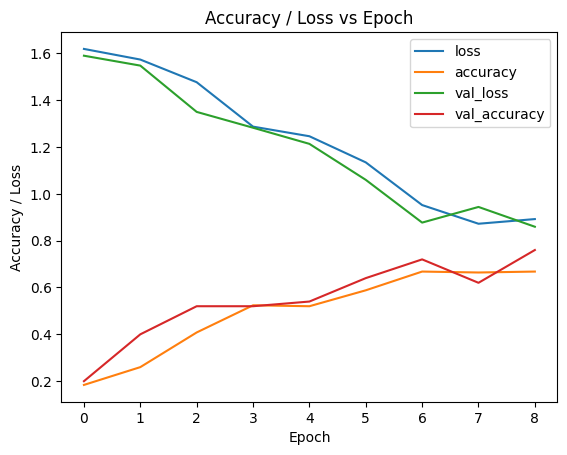

2023-04-24 21:54:49.353866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


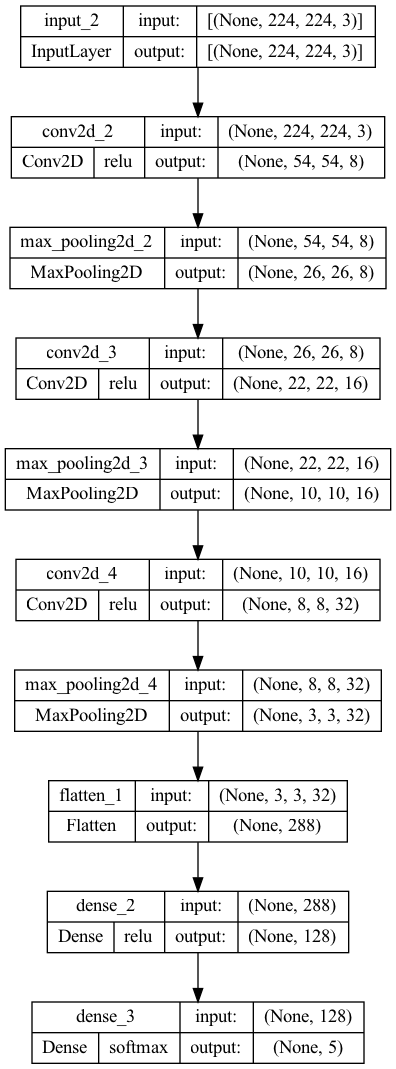

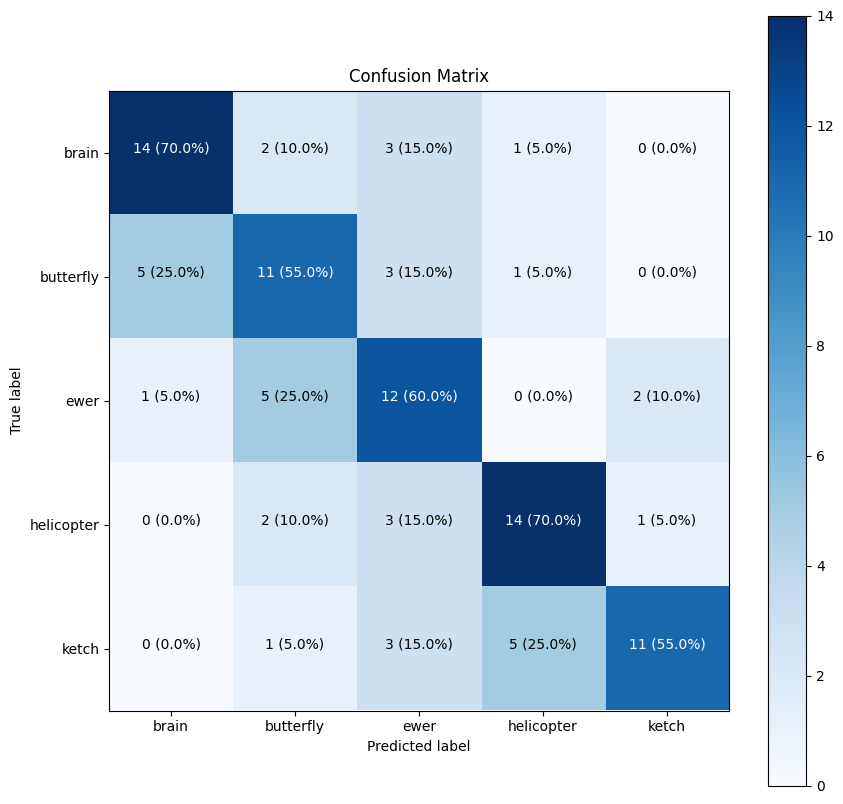

In [11]:
tf.random.set_seed(random_state_global)

model_2 = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  
  keras.layers.Conv2D(filters=8, kernel_size=11, strides=4, activation="relu", kernel_initializer=initializer_1),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="relu", kernel_initializer=initializer_2),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", kernel_initializer=initializer_3),
  keras.layers.MaxPool2D(pool_size=3, strides=2),

  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu", kernel_initializer=initializer_4),
  
  keras.layers.Dense(5, activation="softmax", kernel_initializer=initializer_5) # binary activation output
], name="model_2")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(),
                    metrics=["accuracy"])

  # Evaluate the model initial losses
initial_train_loss, initial_train_acc = model_2.evaluate(train_data, verbose=0)
initial_valid_loss, initial_valid_acc = model_2.evaluate(valid_data, verbose=0)

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=epoch_val,
                        validation_data=valid_data,
                        callbacks=[model_saver, HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), early_stopping_cb],
                        verbose=1)

df_history_2 = pd.DataFrame(history_2.history)
showResults(model_2, df_history_2)
plot_model(model_2,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

### Architecture-3   (6-layer architecture)

2023-04-24 21:54:50.204332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3000


2023-04-24 21:54:50.789699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 42ms/step - loss: 1.6093 - accuracy: 0.2120 - val_loss: 1.5966 - val_accuracy: 0.2400
Epoch 2/3000
8/8 [==============================] - 0s 30ms/step - loss: 1.5912 - accuracy: 0.2640 - val_loss: 1.5742 - val_accuracy: 0.2600
Epoch 3/3000
8/8 [==============================] - 0s 31ms/step - loss: 1.5172 - accuracy: 0.3960 - val_loss: 1.3692 - val_accuracy: 0.4800
Epoch 4/3000
8/8 [==============================] - 0s 33ms/step - loss: 1.4304 - accuracy: 0.4600 - val_loss: 1.5066 - val_accuracy: 0.3800
Epoch 5/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.2957 - accuracy: 0.4480 - val_loss: 1.1459 - val_accuracy: 0.5200
Epoch 6/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.1868 - accuracy: 0.5240 - val_loss: 1.1250 - val_accuracy: 0.5000
Epoch 7/3000
8/8 [==============================] - 0s 29ms/step - loss: 1.1380 - accuracy: 0.6040 - val_loss: 1.0435 - val_accuracy: 0.5400
Epoch 8/3000
8/8 [========

INFO:tensorflow:Assets written to: model_history/part_a/model_3_14.tf/assets


INFO:tensorflow:Assets written to: model_history/part_a/model_3_14.tf/assets


Epoch 14: early stopping
Training Accuracy for model: 78.80%
Validation Accuracy for model: 68.00%
Test Accuracy for model: 64.00%


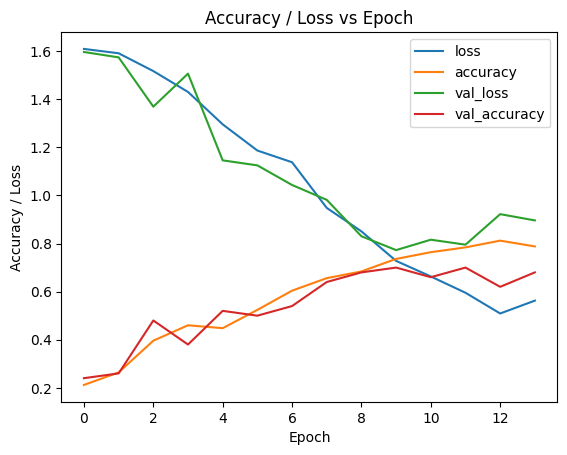

2023-04-24 21:54:56.541659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


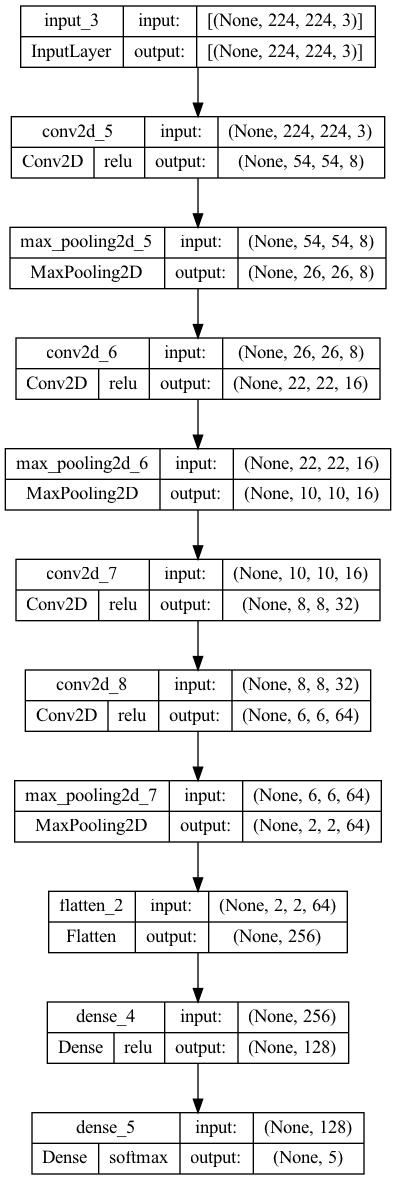

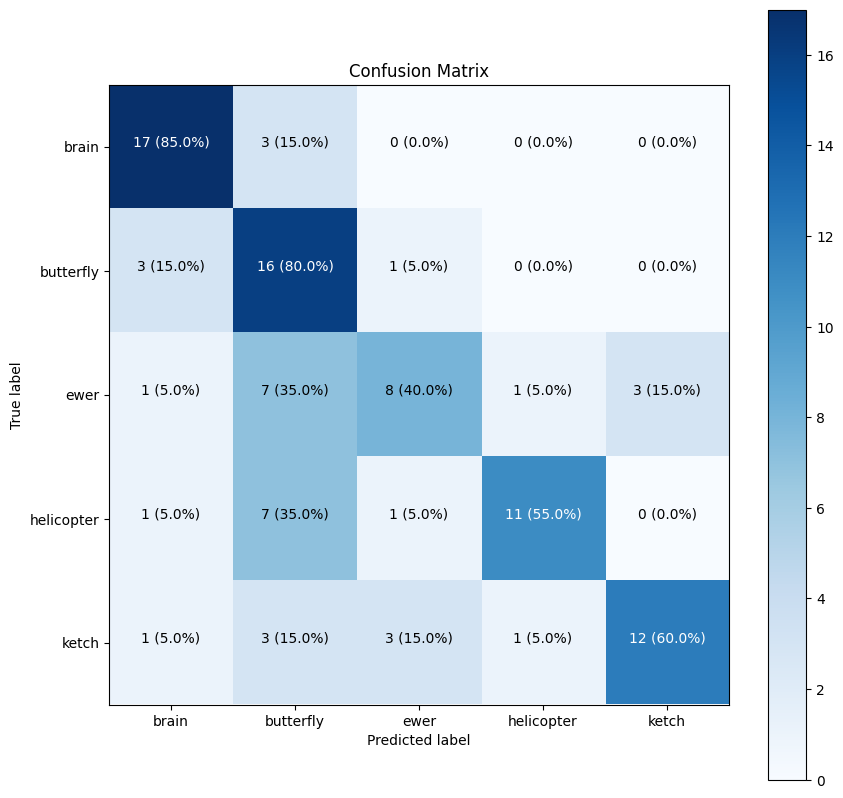

In [12]:
tf.random.set_seed(random_state_global)

model_3 = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  
  keras.layers.Conv2D(filters=8, kernel_size=11, strides=4, activation="relu", kernel_initializer=initializer_1),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="relu", kernel_initializer=initializer_2),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", kernel_initializer=initializer_3),

  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", kernel_initializer=initializer_4),
  keras.layers.MaxPool2D(pool_size=3, strides=2),

  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu", kernel_initializer=initializer_5),
  
  keras.layers.Dense(5, activation="softmax", kernel_initializer=initializer_6) # binary activation output
], name="model_3")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(),
                    metrics=["accuracy"])

  # Evaluate the model initial losses
initial_train_loss, initial_train_acc = model_3.evaluate(train_data, verbose=0)
initial_valid_loss, initial_valid_acc = model_3.evaluate(valid_data, verbose=0)

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=epoch_val,
                        validation_data=valid_data,
                        callbacks=[model_saver, HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), early_stopping_cb],
                        verbose=1)

df_history_3 = pd.DataFrame(history_3.history)
showResults(model_3, df_history_3)
plot_model(model_3,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

In [13]:
delete_folder_contents(pathfinal2)